In [1]:
#initiate imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime,timezone,timedelta
import json
import math
from scipy.stats import linregress
import cbpro

--------------------------------------------------------------------------------------

In [2]:
#api for nomics https://api.nomics.com/
apk="m_9386cac54693578a1cbfb3729a22c0c080769888"

In [5]:
#NOMICS is 8 hours ahead
#exchange history
def new_request(crypto,my_limit,start_date,start_time):
    url = f'https://api.nomics.com/v1/trades?key={apk}&exchange=binance&market={crypto}USDT&limit={my_limit}&order=asc&from={start_date}{start_time}'
    return requests.get(url).json()

In [103]:
#this will be a function to update utc time
def add_second_nomics(df):
    my_last_time=str(df.iloc[-1]['timestamp'])
    my_last_time=pd.to_datetime(my_last_time,utc=True)+ timedelta(seconds=2)
    my_last_time=str(my_last_time)

    parse=my_last_time.split(' ')
    parse_time=parse[1].split(':')
    #then if time is less than time
    parse_time
    my_new_time='T'+parse_time[0]+'%3A'+parse_time[1]+'%3A'+parse_time[2].split(".")[0].split('+')[0]+'Z'
    my_new_date=parse[0]
    my_new_utc=my_new_date+'T'+parse_time[0]+':'+parse_time[1]+':'+parse_time[2].split(".")[0].split('+')[0]+'Z'
    
    #print(parse_time)
    return [my_new_time,my_new_date,my_new_utc]

In [107]:
def get_historical_data(the_crypto,the_date,the_time,end_time):

    #build data frame for expressed time and crypto
    #UCT time is 8 hours ahead, so this would be 02:00:00am PST
    request_num=2

    crypto=the_crypto
    start_time=the_time
    start_date=the_date
    my_limit=2500
    my_df_lenght=my_limit

    #the initial request
    df=pd.DataFrame(new_request(crypto,my_limit,start_date,start_time))
    print(f'request: {1}')


    #loop while conditions are true
    my_conditions=True
    my_limit=len(df)


    while my_conditions:
        
        start_time,start_date,utc_time=add_second_nomics(df)
        if (pd.to_datetime(utc_time)<pd.to_datetime(end_time)):
            my_conditions=True  
        else:
            my_conditions=False

        if (my_conditions):
            print(start_time)
            new_df=pd.DataFrame(new_request(crypto,my_limit,start_date,start_time))
            df=pd.concat([df, new_df])
            df.reset_index(inplace=True)
            del df['index']
            my_df_lenght=len(df)
            print(f'request: {request_num} and new df lenght is {my_df_lenght}')
            request_num=request_num+1
            
        

    return df
  

In [108]:
#!!!!!!!!!!!!!!!!!!!!  RUN THIS FOR HISTORIAL NOMIC  !!!!!!!!!!!!!!!!!!!!
#is 8 hours ahead
df=get_historical_data('BTC','2021-12-12','T20%3A30%3A00Z','2021-12-13T00:30:02.000Z')
start_time,end_time,utc_time=add_second_nomics(df)

request: 1
T20%3A36%3A44Z
request: 2 and new df lenght is 5000
T20%3A44%3A47Z
request: 3 and new df lenght is 7500
T20%3A51%3A32Z
request: 4 and new df lenght is 10000
T20%3A58%3A49Z
request: 5 and new df lenght is 12500
T21%3A05%3A03Z
request: 6 and new df lenght is 15000
T21%3A11%3A08Z
request: 7 and new df lenght is 17500
T21%3A18%3A36Z
request: 8 and new df lenght is 20000
T21%3A26%3A55Z
request: 9 and new df lenght is 22500
T21%3A34%3A05Z
request: 10 and new df lenght is 25000
T21%3A38%3A52Z
request: 11 and new df lenght is 27500
T21%3A42%3A02Z
request: 12 and new df lenght is 30000
T21%3A45%3A19Z
request: 13 and new df lenght is 32500
T21%3A50%3A50Z
request: 14 and new df lenght is 35000
T21%3A54%3A08Z
request: 15 and new df lenght is 37500
T21%3A59%3A53Z
request: 16 and new df lenght is 40000
T22%3A06%3A00Z
request: 17 and new df lenght is 42500
T22%3A12%3A57Z
request: 18 and new df lenght is 45000
T22%3A18%3A58Z
request: 19 and new df lenght is 47500
T22%3A25%3A40Z
request: 20 

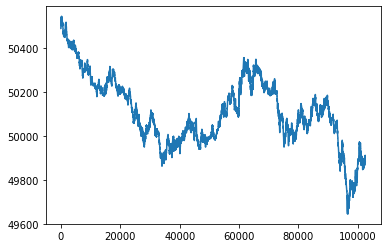

In [111]:
my_x=df.price.astype(float)
plt.plot(my_x)

--------------------------------------------------------------------------------------

In [302]:
datetime.now()

datetime.datetime(2022, 1, 3, 12, 32, 44, 24545)

In [311]:
#!!!!!!!!!!!!!!!!!!!!  RUN THIS FOR HISTORIAL COINBASE  !!!!!!!!!!!!!!!!!!!!
def coinbase_historical(crypto):
    #COINBASE
    #exchange history 20210404T040404Z
    #four hours behind
    request_num=0
    c = cbpro.PublicClient()

    #change these to modify
    the_start='2021-12-21T04:00:00'
    finish_date='2022-01-03T19:30:00'

    #breaks it down to 1 hour searches
    the_end=str(pd.to_datetime(the_start)+timedelta(hours=10))

    #run through it once
    historical = pd.DataFrame(c.get_product_historic_rates(product_id=crypto, start=the_start,
                                                           end=the_end, granularity=300))
    historical.columns= ["Date","Open","High","Low","Close","Volume"]
    historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
    historical.set_index('Date', inplace=True)
    historical.sort_values(by='Date', ascending=True, inplace=True)

    #loop through until finish is met
    date_reached=False
    while date_reached==False:
        if (historical.iloc[-1].name<pd.to_datetime(finish_date)):
                the_start=(historical.iloc[-1].name+timedelta(minutes=5))
                the_end=(historical.iloc[-1].name+timedelta(hours=10))
                new_df=pd.DataFrame(c.get_product_historic_rates(product_id=crypto, start=str(the_start),
                                                                 end=str(the_end), granularity=300))
                new_df.columns= ["Date","Open","High","Low","Close","Volume"]
                new_df['Date'] = pd.to_datetime(new_df['Date'], unit='s')
                new_df.set_index('Date', inplace=True)
                new_df.sort_values(by='Date', ascending=True, inplace=True)
                historical=pd.concat([historical, new_df])
                my_df_lenght=len(historical)
                print(f'request: {request_num} and new df lenght is {my_df_lenght}')
                request_num=request_num+1
        else:
            date_reached=True
            
    return historical

In [340]:
df=coinbase_historical('ASM-USDT')

request: 0 and new df lenght is 128
request: 1 and new df lenght is 199
request: 2 and new df lenght is 257
request: 3 and new df lenght is 318
request: 4 and new df lenght is 361
request: 5 and new df lenght is 434
request: 6 and new df lenght is 479
request: 7 and new df lenght is 527
request: 8 and new df lenght is 571
request: 9 and new df lenght is 620
request: 10 and new df lenght is 710
request: 11 and new df lenght is 763
request: 12 and new df lenght is 839
request: 13 and new df lenght is 912
request: 14 and new df lenght is 987
request: 15 and new df lenght is 1062
request: 16 and new df lenght is 1130
request: 17 and new df lenght is 1212
request: 18 and new df lenght is 1271
request: 19 and new df lenght is 1334
request: 20 and new df lenght is 1380
request: 21 and new df lenght is 1410
request: 22 and new df lenght is 1450
request: 23 and new df lenght is 1505
request: 24 and new df lenght is 1562
request: 25 and new df lenght is 1607
request: 26 and new df lenght is 1640

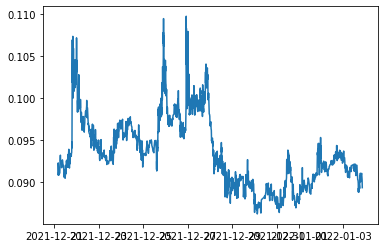

In [341]:
plt.plot(df.iloc[0:].Close)

9.23822709141214e-06
 max: 0.09531
 median: 0.09121213333333333
 min: 0.08695
Date
2022-01-03 20:35:00    0.979585
Name: Close, dtype: float64


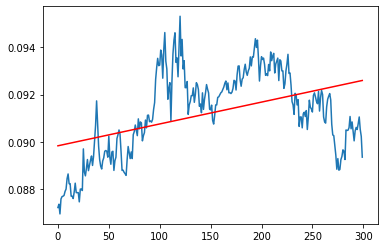

In [343]:
#while (abs(slope)>.5):
window=df.iloc[1553:len(df)]
x = np.arange(0,len(window))
y = window.Close
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept  
regress_values=x*slope+intercept

plt.plot(x,y)
plt.plot(x,regress_values,'-r')
print(slope)
print(f' max: {window.Close.max()}')
print(f' median: {window.Close.mean()}')
print(f' min: {window.Close.min()}')

print(window.iloc[len(window)-1:].Close/window.Close.mean())

In [ ]:
#create my client
auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)

In [ ]:
def get_products():
    my_products=auth_client.get_products()
    avail_products=[]

    for product in my_products:

        if (product['id'].split('-')[1]=='USDT'):
            if (product['cancel_only']==False and product['limit_only']== False and
                product['trading_disabled']== False and product['auction_mode']==False and
                product['fx_stablecoin']==False): 
                avail_products.append(product['id'].split('-')[0])#'trading_disabled''limit_only': True, 'cancel_only':
    #print (avail_products)
    #print (len(avail_products))
    return (avail_products)

In [357]:
product_pool=get_products()

In [362]:
#this will cycle through and I'll have it give the chance to see and then decide to include or not
from IPython.display import clear_output
my_array=[]
for product in product_pool:
    print(product)
    
    clear_output(wait=True)
    keep=input("Keep this? (y/n)")
    if keep=='y':
        my_array.append(product)
    

Keep this? (y/n)n


In [363]:
print(my_array)

['POLY', 'DOGE', 'POLS', 'MASK', 'ASM', 'GALA', 'AXS', 'ETH']


In [342]:
#this will use linear regression to try and weed out spikes
stable_currency=True #assumes currency is stable at the start
start_point=len(df)-300
window=df.iloc[start_point:len(df)]
x = np.arange(0,len(window))
y = window.Close
slope, intercept, r_value, p_value, std_err = linregress(x, y)
slope

#go backwards until slope is less than .5 (absolute value)
while (abs(slope)>.5 and start_point>0):
    start_point=start_point-10
    window=df.iloc[start_point:len(df)]
    #print(start_point)
    x = np.arange(0,len(window))
    y = window.Close
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

#checks to make sure the condition has been met
if (start_point<0 and abs(slope)>.5):
    #condition has not been met
    stable_currency=False
    
#now fine tune the start point if conditions have been met
if (stable_currency==True):
    old_slope=slope
    print(start_point)
    while (abs(old_slope)>=abs(slope) and start_point>0): #need to add an or if the slope never makes it
        old_slope=slope
        start_point=start_point-10
        window=df.iloc[start_point:len(df)]
        x = np.arange(0,len(window))
        y = window.Close
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        #print(f'slope: {slope}')
        #print(f'old slope: {old_slope}')

    #add 10 to start_point to negate the final 10 taken off in the last step
    start_point=start_point+10
    window=df.iloc[start_point:len(df)]       

    #makes sure the most recent price is aligned with the generated window    
    last_value=window.iloc[len(window)-1:].Close[0]
    mean_value=window.Close.mean()

    if (last_value<=mean_value):
        check_percent=(last_value/mean_value)
    else:
        check_percent=(mean_value/last_value)

    if (check_percent<.978):
        print('the current price is too far of the window mean')
        stable_currency=False
        
if (stable_currency):
    #conditions have been met so return
    print (f'start point: {start_point}')
    print (f'check percent: {check_percent}')
else:
    print('the conditions have not been met so leave currency out this time')
    

    

1553
start point: 1553
check percent: 0.9795845874306196


In [349]:
#create function that initiates all potential currencies
#append potential currencies once hits certain number? or delete currency if it makes a big swing
#4 slots of currency
#testing out on just the above sample and if it starts to work will apply it to all
count=0
hold=1
active=True
print(buy_value)

print(f'median value at start: {mean_value}')

while(active):
    
    time.sleep(5)
    
    count=count+1
    if (count>30):
        print (f'current ticker: {ticker}')
        count=0
        
    ticker=float(ticker_update('ASM').json()['price']) 
    if (ticker<mean_value*.99 and hold==0):
        print('!!!!!!!!!!!!!!!!!')
        print(f'buy at: {ticker}')
        print('!!!!!!!!!!!!!!!!!')
        buy_value=ticker
        hold = 1
        
    if (ticker>buy_value*1.02 and hold==1):
        print('!!!!!!!!!!!!!!!!!')
        print(f'sell at {ticker}')
        print('!!!!!!!!!!!!!!!!!')
        sell_value=ticker
        active=False
    
print (f'You made: {sell_value/buy_value*1000}')#buy at .45312

0.08963
median value at start: 0.09121213333333333
current ticker: 0.09027
current ticker: 0.09038
current ticker: 0.09012
current ticker: 0.09004
current ticker: 0.09006
current ticker: 0.08974
current ticker: 0.09029
current ticker: 0.09014
current ticker: 0.09029
current ticker: 0.09038
current ticker: 0.09023
current ticker: 0.09001
current ticker: 0.08977
current ticker: 0.09004
current ticker: 0.09005
current ticker: 0.09025
current ticker: 0.09026
current ticker: 0.09038
current ticker: 0.09027
current ticker: 0.09037
current ticker: 0.08978
current ticker: 0.08962
current ticker: 0.08933
current ticker: 0.08946
current ticker: 0.08968
current ticker: 0.08991
current ticker: 0.08981
current ticker: 0.08997
current ticker: 0.08893
current ticker: 0.08893
current ticker: 0.0887
current ticker: 0.08872
current ticker: 0.08894
current ticker: 0.08878


KeyboardInterrupt: 

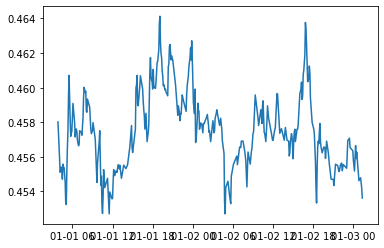

In [297]:
plt.plot(window.Close)

In [237]:
#historical2=historical
#historical2.reset_index(inplace=True) - changed to numbers instead of dates
x = df.index
#x=np.arange(len(historical))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)

regress_values=x*slope+intercept
plt.plot(y)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.965,'-g')
plt.plot(x,regress_values*1.035,'-y')


UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [281]:
trunc_df=pd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[0:244] #12 hours
#historical2=historical
#historical2.reset_index(inplace=True) - changed to numbers instead of dates
x = trunc_df.index
#x=np.arange(len(historical))
y = trunc_df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)

regress_values=x*slope+intercept
plt.plot(y)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.99,'-g')
plt.plot(x,regress_values*1.01,'-y')

slope

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [3]:
next_time_marker=datetime.now()+timedelta(minutes=5)

new_time=False
if (datetime.now()>=next_time_marker):
    new_time=True
    print('hit new time')
    


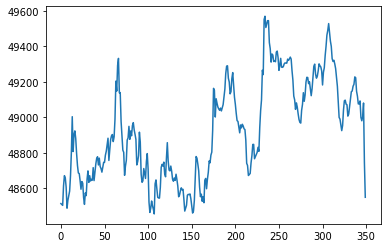

In [98]:
plt.plot(window)

0
request: 0 and new df lenght is 98
request: 1 and new df lenght is 132
request: 2 and new df lenght is 153
request: 3 and new df lenght is 176
request: 4 and new df lenght is 185
request: 5 and new df lenght is 198
198


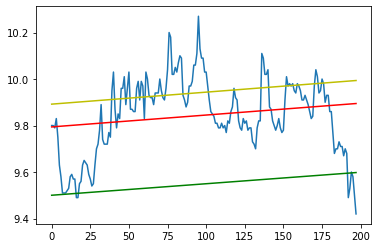


buy price: 9.26
transaction fee$50.0
at: 2021-12-22 17:38:23.998169

time update: 2021-12-22 17:42:09.963257
ticker update: 9.26

updated buy price: $9.598817412551142
updated sell price: $9.9946449347182

time update: 2021-12-22 17:47:12.106571
ticker update: 9.25

updated buy price: $9.599312490076903
updated sell price: $9.995160427812035

time update: 2021-12-22 17:52:17.294434
ticker update: 9.21

updated buy price: $9.599807567602666
updated sell price: $9.995675920905867

time update: 2021-12-22 17:57:18.350800
ticker update: 9.2

updated buy price: $9.600302645128426
updated sell price: $9.996191413999702

time update: 2021-12-22 18:02:20.040785
ticker update: 9.21

updated buy price: $9.600797722654187
updated sell price: $9.996706907093536

time update: 2021-12-22 18:07:21.960727
ticker update: 9.23

updated buy price: $9.60129280017995
updated sell price: $9.99722240018737

time update: 2021-12-22 18:12:22.924342
ticker update: 9.25

updated buy price: $9.60178787770571
upd

KeyboardInterrupt: 

In [271]:
## !!!!!!!!!!!!!!!!
#when it goes into buy it currenlty just doess 5 minutes but the prediction line needs to update every 5 + 10 + 15, etc.
#so predict_line=slope*(len(window)+1)+intercept ... predict_line=slope*(len(window)+2)+intercept
#okay, did it for live but need to update for historical - and should check to make sure it works, gives updates of
#new value to hit every five minutes

#oh and a switch true or false in case need to run without resetting variablesf
#catch error if authentification doesn't work?
#things to experiment with down the line
#will adding an r squared guard help? or help give an adjusted range?
#predict against a giant all - perhaps take out of the line up for awhile?
#slope modifes risk?
#add ticker function above and auth passwords up above
#normalize

restart=False #set this to false on new start or true on crash (for live run only)
print(hold)
if (restart==False):
    hold=0
    total=10000
    fee=0
    fee_rate=.005
    buy_perc=.97
    sell_perc=1.01
    buy_hit_number=0
    sell_hit_number=0


is_live=True

if(is_live):
    if (restart==False):
        #c = cbpro.PublicClient()
        #  right now I manually get the window but I want to add that as a function 
        #444
        #historical = pd.DataFrame(c.get_product_historic_rates(product_id='ETH-USDT', granularity=300))
        #historical.columns= ["Date","Open","High","Low","Close","Volume"]
        #historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
        #historical.set_index('Date', inplace=True)
        #historical.sort_values(by='Date', ascending=True, inplace=True)
        historical=coinbase_historical('PERP-USDT')
        print(len(historical))
    window=historical.High.to_numpy()

        #appends the window every 5 minutes
    next_time_marker=datetime.now()+timedelta(minutes=5)

    
    x = np.arange(0,len(window))
    y = window
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    predict_line=slope*(len(window)+1)+intercept  
    regress_values=x*slope+intercept
    
    plt.plot(x,y)
    plt.plot(x,regress_values,'-r')
    plt.plot(x,regress_values*buy_perc,'-g')
    plt.plot(x,regress_values*sell_perc,'-y')
    plt.show()
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    
    while True:#currently have no exit
        
        
        
        time.sleep(5)
        ticker=float(ticker_update('PERP').json()['price'])  
        

        if (ticker<predict_line*buy_perc and hold==0):
                buy_hit_number=ticker
                hold=1

        if (hold==1 and ticker>buy_hit_number):
            buy_price=ticker
            print('')
            print(f'buy price: {buy_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {datetime.now()}')
            print('')
            fee=fee+(total*fee_rate)
            count=1
            predict_line=slope*(len(window)+count)+intercept
            hold=2

        else:
            buy_hit_number=ticker

        if (hold==2 and (ticker>predict_line*sell_perc or ticker>buy_price*1.2)):
            sell_hit_number=ticker
            hold=3


        if (hold==3 and ticker<sell_hit_number):
            sell_price=ticker
            print('')
            print(f'sell price: {sell_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {datetime.now()}')
            print('')
            hold=0

            print('--------------------')
            print(f'You made: ${(sell_price/buy_price*total)-total}')
            total=sell_price/buy_price*total
            fee=fee+(total*fee_rate)
            
            #gets new slope since it hasn't been doing it during the buy sell period
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*(len(window)+1)+intercept
            print(f'new slope: {slope}')
            
        else:
            sell_hit_number=ticker

        #update window and regression line every five minutes or whatever is set above
        if (datetime.now()>=next_time_marker):
            print(f'time update: {datetime.now()}')
            print(f'ticker update: {ticker}')
            
            #resets new time
            next_time_marker=datetime.now()+timedelta(minutes=5)
        
            window = np.delete(window, (0), axis=0)
            window = np.append(window, ticker)
            y = window
             
            if (hold==0):#doesn't update predict line during buy and sell mode       
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                predict_line=slope*(len(window)+1)+intercept
                print(f'new slope: {slope}')
            else:
                predict_line=slope*(len(window)+count)+intercept
                count=count+1
                print("")
                print(f'updated buy price: ${predict_line*buy_perc}')
                print(f'updated sell price: ${predict_line*sell_perc}')
                print("")


#------------------------------------------------------------------------------    
  

if(is_live==False):
    
    window=historical.iloc[0:4000].High.to_numpy()
    df=historical.iloc[4001:]
    #window=cd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[0:144].High.to_numpy()#or however long
    #df=pd.read_csv("BTC_2021_11_12_coinbase.csv").iloc[len(window):288]

    x = np.arange(0,len(window))
    y = window
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    predict_line=slope*(len(window)+1)+intercept                    
    
    for i, j in df.iterrows():



        if (j.Close<window.mean()*.97):
            buy_hit_number=j.Close
            hold=1

        if (hold==1 and j.Close>buy_hit_number):
            buy_price=j.Close
            print('')
            print(f'buy price: {buy_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {i}')
            print('')
            fee=fee+(total*fee_rate)
            hold=2

            #regress_values=x*slope+intercept
            #plt.plot(df.Close)
            #plt.plot(x,regress_values,'-r')
            #plt.plot(x,regress_values*.99,'-g')
            #plt.plot(x,regress_values*1.01,'-y')


        else:
            buy_hit_number=j.Close

        if (hold==2 and (j.Close>window.mean()*1.03)):
            sell_hit_number=j.Close
            hold=3


        if (hold==3 and j.Close<sell_hit_number):
            sell_price=j.Close
            print('')
            print(f'sell price: {sell_price}')
            print(f'transaction fee${total*fee_rate}')
            print(f'at: {i}')
            print('')
            hold=0

            print('--------------------')
            print(f'You made: ${(sell_price/buy_price*total)-total}')
            total=sell_price/buy_price*total
            fee=fee+(total*fee_rate)
            
            #gets new slope since it hasn't been doing it during the buy sell period
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*(len(window)+1)+intercept
            print(f'new slope: {slope}')
            count=0
            
        else:
            sell_hit_number=j.Close

        #update window and regression line
        window = np.delete(window, (0), axis=0)
        window = np.append(window, j.Close)
        y = window
        if (hold==0):#doesn't update predict line during buy and sell mode
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            predict_line=slope*len(window)+intercept

    #if it ends without a sale
    if (hold==10):#change this to 0 if want to have it sell at end of df
        sell_price=j.Close
        sell_price=j.Close
        print('')
        print(f'sell price: {sell_price}')
        print(f'transaction fee${total*fee_rate}')
        print(f'at: {i}')
        print('')
        hold=0

        print('--------------------')
        print(f'You made: ${(sell_price/buy_price*total)-total}')
        total=sell_price/buy_price*total
        fee=fee+(total*fee_rate)
        print('ditch sell')
    


    print('--------------------')
    print('--------------------')
    print(f'final total is ${total}')
    print(f'final fee is ${fee}')
    print(f'You made ${total-fee}')
    print('--------------------')
    print('--------------------')



ValueError: x and y must have same first dimension, but have shapes (4099,) and (197,)

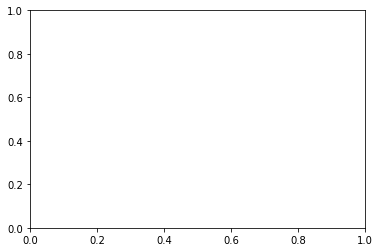

In [269]:
## t = np.arange(0,len(window)+len(df.High))
b = np.concatenate((window,df.High))

x = np.arange(0,len(window))
y = window
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 


regress_values=x*slope+intercept
plt.plot(t,b)
plt.plot(x,regress_values,'-g')
plt.plot(x,regress_values*1.01,'-g')
plt.plot(x,regress_values*1.03,'-g')
slope

x = np.arange(len(window),len(window)+len(df.High))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 

regress_values=x*slope+intercept
#plt.plot(x,df.High)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.98,'-r')
plt.plot(x,regress_values*1.02,'-r')
#slope

window.mean()

In [163]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-26 23:30:00,53635.71,53719.48,53693.44,53715.99,1.030364
2021-11-26 23:35:00,53736.14,53978.28,53750.90,53800.99,3.247215
2021-11-26 23:40:00,53590.99,53855.13,53855.13,53641.33,0.835151
2021-11-26 23:45:00,53560.14,53830.83,53633.69,53795.20,1.734714
2021-11-26 23:50:00,53653.69,53836.24,53827.62,53657.97,0.435639
...,...,...,...,...,...
2021-12-22 11:40:00,48991.63,49092.60,49064.68,48991.63,0.278045
2021-12-22 11:45:00,48949.27,48999.97,48978.93,48969.04,0.819765
2021-12-22 11:50:00,48908.70,48980.79,48980.79,48960.48,1.150554


-0.522580636733936

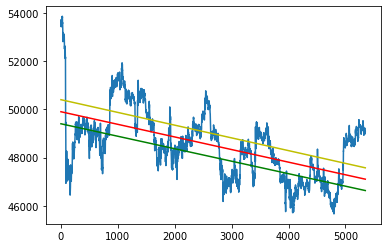

In [135]:
x = np.arange(0,len(df.High))
y = df.High
slope, intercept, r_value, p_value, std_err = linregress(x, y)
predict_line=slope*(len(window)+1)+intercept 

regress_values=x*slope+intercept
plt.plot(x,df.High)
plt.plot(x,regress_values,'-r')
plt.plot(x,regress_values*.99,'-g')
plt.plot(x,regress_values*1.01,'-y')
slope

In [1192]:
df=historical
#can upload this: 'dec_2_spike_kmd.csv'
#test bot
hold=0#default
buy_price=0 #default
old_price=1.2 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.Close<regress_values*.98 and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

#maybe not reinvest all option so if It hits 500 keeps 250 for a guaranteed profit?
#and when it hits check to see if there recent twitter post counts?
#time limit or too low?
#perhaps check to see trend and if it jumps by a percentage even if it isn't a new high? 10%?  track new low after new high and if suddenly it jumps up even if it isn't at new high buy again?
#check predictions? in the api

num=20614
2021-12-02T15:56:40.809Z
num=68625
2021-12-02T17:58:18.47Z
num=76033
2021-12-02T18:01:44.625Z
1.4888
1.4287
You made $1317.4185090772808


In [1191]:

df=pd.read_csv('dec_6_spike_kmd.csv')
#test bot
hold=0#default
buy_price=0 #default
old_price=.86 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.price>old_price and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

num=5500
2021-12-06T16:03:52.921Z
num=8457
2021-12-06T16:07:45.348Z
0.8603
0.9531
You made $428.5598047192834


In [ ]:
################## MY MILLIONAIRE BOT #######################

In [718]:
import cbpro

In [737]:
#get available products
pc=cbpro.PublicClient()
results=pc.get_products()
for row in results:
    print(row['id'])

CHZ-USD
PAX-USD
FIL-USD
REN-BTC
PERP-USD
ETH-USDC
NKN-USD
BAT-BTC
CRV-BTC
CTSI-USD
CVC-USDC
FX-USD
STORJ-BTC
ZEC-USD
ZRX-USD
DASH-BTC
AXS-BTC
MASK-USDT
UST-EUR
MASK-USD
LCX-USDT
VGX-USD
MIR-BTC
ADA-EUR
DOGE-USDT
CVC-USD
NU-USD
RAD-USD
BAND-EUR
WLUNA-GBP
ENJ-BTC
LTC-USD
SNX-EUR
NU-GBP
KRL-USDT
NMR-EUR
OMG-EUR
TRAC-USD
NMR-USD
ZRX-EUR
REN-USD
POLY-USD
GTC-USD
YFI-BTC
ALCX-USDT
ETC-BTC
MCO2-USDT
RLY-GBP
LCX-EUR
GRT-USD
UST-USDT
ETH-USDT
CRV-EUR
UMA-EUR
XLM-USD
BCH-BTC
CLV-GBP
ALCX-EUR
SNX-GBP
NMR-BTC
EOS-EUR
XYO-USDT
IOTX-USDT
MANA-ETH
UMA-BTC
TRIBE-USD
DOGE-USD
RAD-GBP
KRL-EUR
OMG-GBP
TRU-USDT
AXS-USD
ETH-BTC
DASH-USD
BTRST-USDT
FIL-EUR
POWR-USDT
RGT-USD
FET-USD
MANA-USDC
LOOM-USDC
ARPA-EUR
FORTH-EUR
STORJ-USD
1INCH-BTC
BAT-EUR
MLN-USD
MIR-GBP
ASM-USD
UNI-USD
BAT-USDC
CRO-EUR
DOGE-GBP
WCFG-GBP
REP-USD
BICO-USD
FOX-USDT
BNT-USD
SOL-GBP
FARM-USDT
MANA-USD
KNC-USD
ZEN-BTC
ETC-USD
AXS-EUR
ENS-USD
ICP-BTC
DDX-USDT
MATIC-USD
IDEX-USD
BTC-USDC
UNI-GBP
ARPA-USD
CGLD-BTC
CHZ-EUR
RAD-EUR
CGLD-GBP


In [287]:
#get my coinbase psscodes
myps=open('../phrase.txt','r').read().splitlines()
public = myps[2].split(':')[1]
passphrase = myps[0].split(':')[1]
secret = myps[1].split(':')[1]

In [353]:
#create my client
auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)

In [354]:
#verify my client
auth_client.get_accounts()

[{'id': '6816884e-323c-4bbe-a17d-19f983531c08',
  'currency': '1INCH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'a6c04dbc-7d9d-47ad-9e00-2496e9c83d55',
  'currency': 'AAVE',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'fd3a3da9-f798-4d37-9a24-95b0e85765a5',
  'currency': 'ACH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '12e1a26d-c4b6-4de5-a58e-ca617e550262',
  'currency': 'ADA',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '980f54ed-c254-4359-84d1-769f

In [7]:
#function to get floor down to two decimal places
def floor_balance(value):
    return math.floor(value*100)/100

In [286]:
#ticker for crypto
def ticker_update(my_ticker):
    import requests
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    url = "https://api.exchange.coinbase.com/products/"+my_ticker+"-USD/ticker"

    headers = {"Accept": "application/json"}

    response = requests.request("GET", url, headers=headers)

    return response

In [9]:
#gets available balance for sell or buy
def get_balance(curr):
    for account in accounts:
        currency=account.get('currency')
        if currency==curr:
            acc_id=account.get('id')
            print(curr)
            print(auth_client.get_account(acc_id))
    return auth_client.get_account(acc_id)['available']

In [10]:
#function to calculate needed value to sell, etc. for bot
def output_req(buy_price,profit_limit,sell_limit):
    purchase=10
    profit_req=buy_price*profit_limit
    high_req =100/(sell_limit*100)*profit_req
    print(f'sell price if only hits minimum: {profit_req}')
    print(f'will at least need to hit this price to auto sell {high_req}')

In [1240]:
print(float(ticker_update('ASM').json()['price']))
print(float(ticker_update('POWR').json()['price']))
print(float(ticker_update('DDX').json()['price']))
print(float(ticker_update('SKL').json()['price']))
print(float(ticker_update('MATIC').json()['price']))

0.09811
0.4723
4.54
0.2132
2.1709


In [351]:
def get_products():
    my_products=auth_client.get_products()
    avail_products=[]

    for product in my_products:

        if (product['id'].split('-')[1]=='USDT'):
            if (product['cancel_only']==False and product['limit_only']== False and
                product['trading_disabled']== False and product['auction_mode']==False and
                product['fx_stablecoin']==False): 
                avail_products.append(product['id'].split('-')[0])#'trading_disabled''limit_only': True, 'cancel_only':
    #print (avail_products)
    #print (len(avail_products))
    return (avail_products)

In [355]:
get_products()#DOGE,CRO,CHZ,SPELL,GALA,KRL,TRU,REQ,RLY,WCFG

['ASM',
 'BICO',
 'TRU',
 'CLV',
 'RLY',
 'SUKU',
 'ETH',
 'SOL',
 'BTC',
 'AUCTION',
 'BTRST',
 'XYO',
 'CRO',
 'ENS',
 'REQ',
 'SHIB',
 'AGLD',
 'WLUNA',
 'GALA',
 'VGX',
 'ARPA',
 'RAD',
 'DDX',
 'ORN',
 'MCO2',
 'ICP',
 'COVAL',
 'MASK',
 'MDT',
 'DOT',
 'TRAC',
 'CHZ',
 'FET',
 'BADGER',
 'KRL',
 'POLS',
 'PERP',
 'AXS',
 'IDEX',
 'ALCX',
 'SPELL',
 'DOGE',
 'LCX',
 'WCFG',
 'POLY',
 'AVAX']

In [1503]:
def normalize(values):
    return (values - values.min())/(values.max() - values.min())
    #return (values - values.min())/(values.max() - values.min())

In [1499]:
y=normalize(pd.DataFrame({'temp':[.1677,.1781]}))
slope, intercept, r_value, p_value, std_err = linregress([0,1],y.temp)
slope

0.01040000000000002

In [1498]:
slope

0.0

In [177]:
float(ticker_update('BTC').json()['price'])

46850.35

In [ ]:
### add an eject button if it hits too low!
#MILLIONAIR BOT

auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
first_run=True #set this to false if cell is interuppted and I want to continue where left off
is_live=False #won't actually buy or sell


#creates a general array for y to help figure out slope of product
win_index=[]#length of the array for window #time sleep every one second then this is about 3 1/2 minutes - corresponds with time below
for i in range(0,90):
    win_index.append(i)


#the possible products    
the_products=get_products()
product_pool={}

for product in the_products:
    product_pool[product]=[]
    
#so! now I need to have it cycle through all available products and each time one matches
#the requirements, it buys and is moved into an available dictionary INCLUDING THE WINDOW
#after it sells it is moved back into circulation
#including the additional funds and the spend adjusts accordingly
        
#!!!! Temporarily overrides the entire product pool until I can find a faster way to cycle through
#the_products=['DOGE','CRO','CHZ','SPELL','GALA','TRU','REQ','RLY','WCFG']
#product_pool={'DOGE':[],'CRO':[],'CHZ':[],'SPELL':[],'GALA':[],'TRU':[],'REQ':[],'RLY':[],'WCFG':[]}    

#initializes the bots - might just be able to do one at a time unless find a way to further limit but for now 1
if (first_run==True):
    dict1 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0,'window':[]}
    #dict2 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0}
    #dict3 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    #dict4 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    
    currencies=[dict1] #start with just 1
    
    available_slots=len(currencies) #match the number of dictionaries possible
    
    hold=0 #0=initial, 1=hold, 2=sold (back to 0 to be put back in circulation)
    
    profit_limit=1 #sets the desired profit before selling
    sell_limit=.98 #will sell if the high price drops to this percentage (if profit limit is met too)
    #high_increase=1.0 #will buy again if price hits the current high multiplied by this
    
    #sets the spend value for each dictionary

    
print ('Bot Started!')
bot_count=0
hit_window=False
    
while True:#currently this keeps running until manually exiting
    
    
    
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    
    #for product in the_products:
        
    price=float(ticker_update('GALA').json()['price'])
      #  product_pool[product].append(price)
        
        #bot_count=bot_count+1
        #if (bot_count==12):
         #   print(f'{product} price update at:{price} - to make sure is still live')
          #  print(len(product_pool[product]))
           # bot_count=0

        #if (len(product_pool[product])>=90):
            #print('yes')
         #   if (hit_window==False):
          #      hit_window=True
           #     print ('Let us get those buys!')
            #x = win_index
            #y = pd.DataFrame({'temp':product_pool[product]}).temp
            
            
            #!!!!!!!! THIS IS MAKING IT GO SLOW!
            #slope, intercept, r_value, p_value, std_err = linregress(x, normalize(y))
            #print(slope)
            #product_pool[product].pop(0)

    in_circulation=True

    #if not in circulation sees if a slot is available for another purchase
    #empty_slot=0 #if 0 there is no available slots for a new purchase
    #slot_count=0
    #the_slot=-1

    #for currency in currencies:

     #   if (currency['crypto']==product): #LINE 74
      #      in_circulation=True
       # if (currency['crypto']==''):
        #    the_slot=slot_count
        #slot_count=slot_count+1


    if (in_circulation==True):
        type_crypto='GALA'
        type_exchange=type_crypto+'-USDT'
        buy_price=currencies[the_slot]['buy_price']
        new_high=currencies[the_slot]['new_high']
        spend=currencies[the_slot]['spend']
        hold=currencies[the_slot]['hold']

    #check to see if it is already bought and in current circulation
    if (hold==0): ##just works with under 1 dollar for now
        #if (the_slot!=-1):
         #   currencies[the_slot]['crypto']=product #adds to the slot


        if (is_live==True):
            original_spend=float(get_balance('USDT')) #amount to spend initially on first buy
        else:
            original_spend=1000

        #currencies[the_slot]['spend']=original_spend/available_slots

        #in_circulation=True
        #available_slots=available_slots-1

        buy_price=price
        new_high=buy_price
        print('')
        print('PURCHASE ORDER:')
        print(f'date: {datetime.now()}')
        print (f'{type_crypto} :${price}')
        #print(f'buy slope: {slope}')
        #print(f'buy r squared: {r_value*r_value}')
        print('')
        print(output_req(buy_price,profit_limit,sell_limit))
        print('')

        if (is_live==True):
            the_bought=(auth_client.place_market_order(type_exchange, 'buy', funds=floor_balance(spend)))

            #checks to see if buy goes through
            if (len(the_bought)==1):
                print (the_bought)
                currencies[the_slot]['spend']=0
                currencies[the_slot]['crypto']=''
                hold=0
                print ('the buy did not go through')
            else:
                output_req(buy_price,profit_limit,sell_limit)
                currencies[the_slot]['hold']=1



    active=True
    while (active==True):
        
        price=float(ticker_update('ASM').json()['price'])

        if (price>new_high):
            new_high=price
            print(new_high)

        if (hold==1 and ((price<=new_high*sell_limit and price>buy_price*profit_limit))):#makes sure there isn't a loss for the sell
            print('')
            print('SELL ORDER:')
            print(f'date: {datetime.now()}')
            print(f'sell price: {price}')
            print(f'sell slope: {slope}')
            print(f'sell r squared: {r_value*r_value}')
            print('')

            if (is_live==True):
                print(auth_client.place_market_order(type_exchange, 'sell', size=floor_balance(float(get_balance(type_crypto)))))
            active=False


    #reset values
    currencies[the_slot]['crypto']=''
    currencies[the_slot]['hold']=0
    currencies[the_slot]['hold']=0
    currencies[the_slot]['new_high']=0
    currencies[the_slot]['spend']=0
    available_slots=available_slots+1

    #back_up values before moving to next currency when several are active but that is not the case now
    #if (currencies[the_slot]!=''):
    #   currencies[the_slot]['buy_price']=buy_price
    #currencies[the_slot]['new_high']=new_high
    #currencies[the_slot]['spend']=spend
    #currencies[the_slot]['hold']=hold


Bot Started!

PURCHASE ORDER:
date: 2021-12-12 08:03:27.789083
GALA :$0.57559

sell price if only hits minimum: 0.57559
will at least need to hit this price to auto sell 0.5873367346938776
None



In [1507]:
len(product_pool[product])

89

In [1189]:
#manually sell my current one
#print(auth_client.place_market_order('MASK-USDT', 'sell', size=floor_balance(float(get_balance('MASK')))))

MASK
{'id': 'f8765463-bde3-4c7c-8c92-4484ba10d156', 'currency': 'MASK', 'balance': '0.9200000000000000', 'hold': '0.0000000000000000', 'available': '0.92', 'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24', 'trading_enabled': True}
{'id': '52125c98-1635-47c0-b4d3-072c04e125fa', 'size': '0.92', 'product_id': 'MASK-USDT', 'side': 'sell', 'stp': 'dc', 'type': 'market', 'post_only': False, 'created_at': '2021-12-10T03:05:23.87493Z', 'fill_fees': '0', 'filled_size': '0', 'executed_value': '0', 'status': 'pending', 'settled': False}


In [857]:
#manually buy
#auth_client.place_market_order('BTC-USDT', 'buy', funds=5)

{'id': '2b89d592-6411-45d2-a397-6bc07c39985b',
 'product_id': 'BTC-USDT',
 'side': 'buy',
 'stp': 'dc',
 'funds': '4.97512437',
 'specified_funds': '5',
 'type': 'market',
 'post_only': False,
 'created_at': '2021-12-08T21:50:28.975657Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

In [1350]:
#manually sell 
#a=auth_client.place_market_order('DDX-USDT', 'sell', funds=1)


In [362]:
k=[1,2,3,4,5]
j=[10,20,30,40,50]

In [367]:
slope*5.5+intercept

55.0

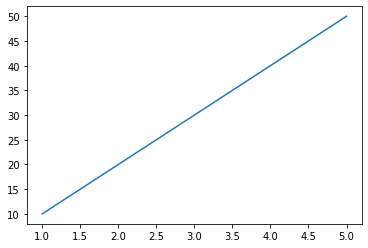

In [363]:
test_df=pd.DataFrame(j,k)

test_df.reset_index(inplace=True)
test_df.columns=['num','score']
test_df
slope, intercept, r_value, p_value, std_err = linregress(test_df['num'], test_df['score'])

regress_values=test_df['score']*slope+intercept
plt.plot(test_df['num'],test_df['score'])
#plt.plot(test_df['score'],regress_values,'-r')
#plt.plot(test_df['score'],regress_values*.96,'-g')
#plt.plot(test_df['score'],regress_values*1.04,'-y')

In [354]:
test_df=pd.DataFrame(j,k)

test_df.reset_index(inplace=True)
test_df.columns=['num','score']
test_df
slope, intercept, r_value, p_value, std_err = linregress(test_df['num'], test_df['score'])

In [35]:
a=[0,5]
a.append(10)
a

[0, 5, 10]

In [36]:
b=a.pop(0)

In [38]:
a

[5, 10]

In [44]:
window

,Unnamed: 0,level_0,index,Date,Open,High,Low,Close,Volume
0,0,0,0,2021-11-16 20:00:00,59893.35,60188.69,60188.68,59992.99,0.704041
1,1,1,1,2021-11-16 20:05:00,59979.60,60159.92,59997.95,60030.96,1.263909
2,2,2,2,2021-11-16 20:10:00,59837.59,60007.35,59987.24,59905.54,7.138614
3,3,3,3,2021-11-16 20:15:00,59600.89,59902.56,59902.56,59770.55,3.807446
4,4,4,4,2021-11-16 20:20:00,59708.14,59876.64,59771.78,59711.45,0.899153
...,...,...,...,...,...,...,...,...,...
239,239,239,239,2021-11-17 15:55:00,59589.08,59691.16,59591.00,59650.03,0.414862
240,240,240,240,2021-11-17 16:00:00,59423.82,59683.72,59666.23,59439.02,0.305816
241,241,241,241,2021-11-17 16:05:00,59427.28,59625.56,59450.29,59625.56,5.341838
242,242,242,242,2021-11-17 16:10:00,59512.51,59887.98,59600.10,59887.98,1.102823


In [ ]:
window